# Feature Engineering

&copy; Sifiso Rimana | May, 2025 | Financial Inclusion - Zindi Competetion

----

In [33]:
import pandas as pd
import numpy as np
import imblearn as imb
from imblearn.datasets import fetch_datasets
from matplotlib import pyplot as plt
import arviz 

plt.style.use('arviz-darkgrid')

import sys
sys.path.append("../scripts")

from scripts.utils import load_model
from scripts.utils import save_model

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [20]:
df = pd.read_csv('../data/Train.csv', index_col='uniqueid')
df.head()

,country,year,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
uniqueid,,,,,,,,,,,,
uniqueid_1,Kenya,2018,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
uniqueid_2,Kenya,2018,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
uniqueid_3,Kenya,2018,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
uniqueid_4,Kenya,2018,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
uniqueid_5,Kenya,2018,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [21]:
df.columns

Index(['country', 'year', 'bank_account', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')

We think there could be some inherent order in location type. For example, those living in urban areas receive more services than those living in rural areas. We plot this to convince ourselves.

In [22]:
df['location_type'].unique()

array(['Rural', 'Urban'], dtype=object)

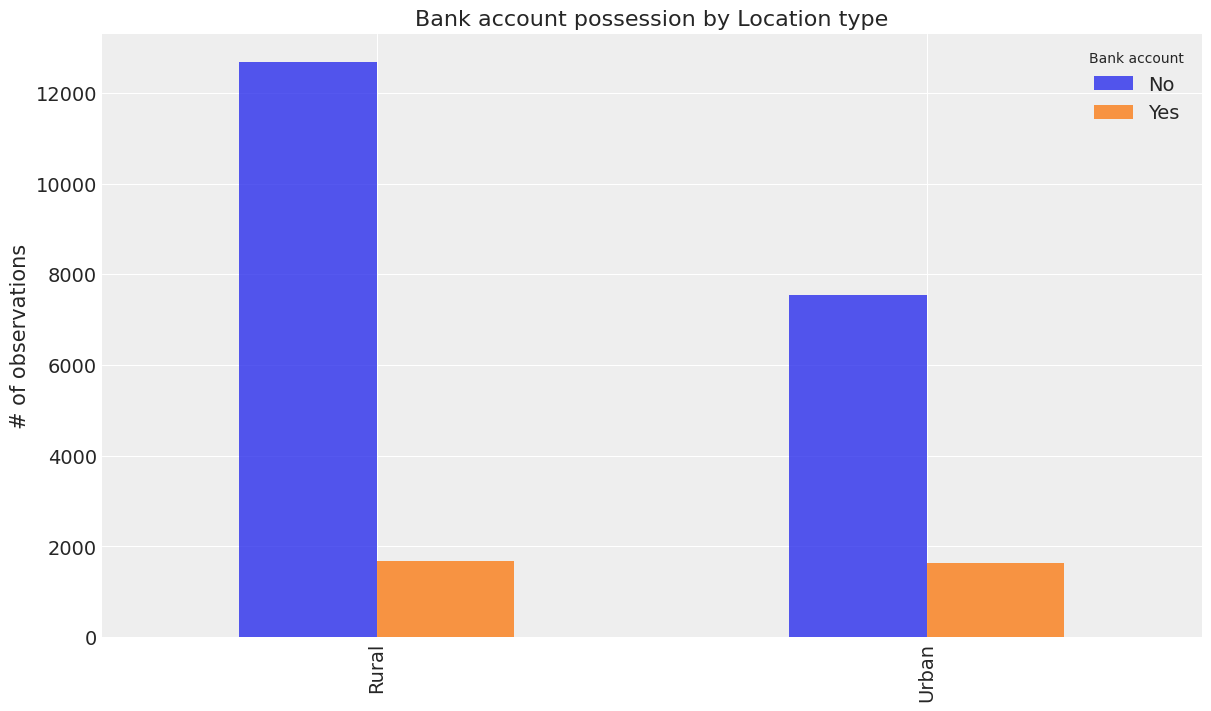

In [10]:
df.groupby(['location_type', 'bank_account']).size().unstack(fill_value=0).plot(
    kind='bar', alpha=0.8, figsize=(12,7)
)

plt.title(f'Bank account possession by Location type')
plt.xlabel(None)
plt.ylabel('# of observations')
plt.legend(title="Bank account")
plt.show()

The plot may be somewhat misleading, let us look at the proportion of people having a bank account in each group.

In [ ]:
n_obs = len(df)

rural_prop = len(df[df['location_type']=='Rural']) / n_obs
urban_prop = len(df[df['location_type']=='Urban']) / n_obs

print(f"Proportion of people in rural areas owning a bank account: {rural_prop}")
print(f"Proportion of people in urban areas owning a bank account: {urban_prop}")

Proportion of people in rural areas owning a bank account: 0.6097177350790682
Proportion of people in urban areas owning a bank account: 0.3902822649209318


In [23]:
df.columns

Index(['country', 'year', 'bank_account', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')

## 1. Building the Preprocessor
---

Our categorical (nominal) variables will be
 - `country`
 - `marital_satus`
 - `gender_of_respondent`
 - `relationship_with_head`

Our ordinal categorical variables will be
- `location_type`
- `cellphone_access`
- `education_level`
- `job_type`

There variables are count data
- `household_size`
- `age_of_respondent`

**Preprocessing steps**

Categorical variables will be transformed as follows
- `OneHotEncoder` will be used for nominal type, and 
- `OrdinalEncoder` will be used for ordinal type

Our target variable `bank_account` will be transformed using the `LabelEncoder`. Count variables will be transfomed using the `MinMaxScaler` 

In [24]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

### 1.1 Building the `ColumnTransformer` preprocessor

In [28]:
ordinals = [
    df['location_type'].unique().tolist(),
    df['cellphone_access'].unique().tolist(),
    df['education_level'].unique().tolist(),
    df['job_type'].unique().tolist()
]

nominals = [
    df['country'].unique().tolist(),
    df['marital_status'].unique().tolist(),
    df['gender_of_respondent'].unique().tolist(),
    df['relationship_with_head'].unique().tolist()
]

nominal_features = ['country', 'marital_status', 'gender_of_respondent', 'relationship_with_head']
ordinal_features = ['location_type', 'cellphone_access', 'education_level', 'job_type']
count_features = ['household_size', 'age_of_respondent']

preprocessor = ColumnTransformer(
    [
        ('ordinal', OrdinalEncoder(dtype=int, categories=ordinals), ordinal_features),
        ('nominal', OneHotEncoder(dtype=int, categories=nominals), nominal_features),
        ('count', MinMaxScaler(), count_features)
    ], 
    sparse_threshold=0 # always output dense
)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(df.drop('bank_account', axis=1), 
                     df['bank_account'], random_state=0, test_size=0.2)

In [35]:
X_train_transformed = preprocessor.fit_transform(X_train)

In [36]:
y_encoder = load_model('../models/bank_account_encoder.pkl')
y_train_transformed = y_encoder.transform(y_train)

In [39]:
save_model(model=preprocessor, filename='preprocessor.pkl')

## 2. Dealing with Class Imbalance

---

<Axes: xlabel='bank_account'>

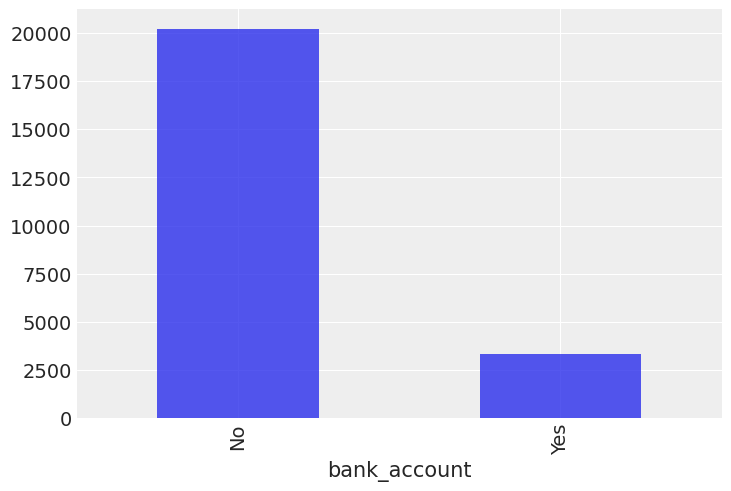

In [30]:
df['bank_account'].value_counts().plot(kind='bar', alpha=0.8)

In [37]:
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train_transformed, y_train_transformed)

smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train_transformed)

### Save results

In [40]:
save_model(model=X_train_ros, filename='X_train_ros.pkl', save_to='../data/')
save_model(model=X_train_smote, filename='X_train_smote.pkl', save_to='../data/')
save_model(model=y_train_ros, filename='y_train_ros.pkl', save_to='../data/')
save_model(model=y_train_smote, filename='y_train_smote.pkl', save_to='../data/')

save_model(model=X_test, filename='X_test.pkl', save_to='../data/')
save_model(model=y_test, filename='y_test.pkl', save_to='../data/')

----